## Electricity Demand in Victoria, Australia

Possible questions: 
- Can we reasonably forecast future demand? This might be useful for power generation management (power plants and power grid).
- Can we identify unusual events? For example, were there any observable effects of the COVID-19 pandemic?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

Data from: https://www.kaggle.com/aramacus/electricity-demand-in-victoria-australia

Data ranging from Jan 1, 2015 to October 6, 2020 (2106 days)

In [2]:
# multivariate time series with daily data from Jan 2015 - Oct 2020
data = pd.read_csv("complete_dataset.csv")
data

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,N,N
2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,N,N
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,N,N
2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,N,N


Variables:
- date: date
- demand: daily electricity demand in MWh
- RRP: average daily recommended retail price ($/Mwh), weighted by intraday demand
- demand_pos_RRP: total daily demand when RRP is positive
- RRP_positive: average positive RRP, weighted by intraday demand
- demand_neg_RRP: total daily demand when RRP is negative
- RRP_negative: average negative RRP, weighted by intraday demand
- frac_at_neg_RRP: fraction of the day (time) when RRP was negative
- min_temperature: minimum daily temperature (celcius)
- max_temperature: maximum daily temperature (celcius)
- solar_exposure: total daily sunlight (MJ/m^2)
- rainfall: daily rainfall (mm)
- school_day: (Y/N)
- holiday: (Y/N)

Note: RRP = (demand_pos_RRP * RRP_positive + demand_neg_RRP * RRP_negative) / demand

### Some data cleaning

In [3]:
# Date from string to datetime format
def date_str_to_dt(date_str):
    return datetime.datetime.strptime(date_str, "%Y-%m-%d")

data["date"] = data["date"].apply(date_str_to_dt)

In [4]:
# School day and holidays: prefer binary (0/1) rather than Y/N
data["school_day"] = data["school_day"].apply(lambda x: 0 if x == "N" else 1)
data["holiday"] = data["holiday"].apply(lambda x: 0 if x == "N" else 1)

In [5]:
data

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,0,1
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,0,0
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,0,0
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,0,0
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,0,0
2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,0,0
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,0,0
2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,0,0


Turns out there are 4 rows with NaNs in the solar exposure and rainfall columns. There are a few ways we could impute these.

Since there are only a few points, I tried looking them up on a website; but since we don't know the original source of the data, I couldn't find a matching source. Alternatively, one might just drop the rows with NaNs.

Since solar exposure is annually cyclical, just take the average solar exposure on that date of the other years.

Rainfall, just put 0.

In [6]:
# check for NaNs
data.isnull().sum()

date               0
demand             0
RRP                0
demand_pos_RRP     0
RRP_positive       0
demand_neg_RRP     0
RRP_negative       0
frac_at_neg_RRP    0
min_temperature    0
max_temperature    0
solar_exposure     1
rainfall           3
school_day         0
holiday            0
dtype: int64

In [7]:
# imputing solar exposure
na_rows = data.loc[data["solar_exposure"].isna()]
    
for index, row in na_rows.iterrows():
    # get date
    month = row["date"].month
    day = row["date"].day

    # calculate avg
    matching_dates = data.loc[(data["date"].dt.month == month).multiply(data["date"].dt.day == day)]
    avg = matching_dates["solar_exposure"].mean()

    # impute
    data.loc[index, "solar_exposure"] = avg

In [8]:
# imputing rainfall
na_rows = data.loc[data["rainfall"].isna()]
for index, row in na_rows.iterrows():
    # impute
    data.loc[index, "rainfall"] = 0

### Data Exploration and Visualization

#### 1. Plotting demand as a univariate time series.

The pattern here is quite standard. We see higher electricity use in the winter months (June-August) for heating, as well as in the summer (December - February) for air conditioning. The peaks for the winter months are smoother than the spikes we observe during the summer months; likely due to the fact that heating is used throughout the winter while air conditioning may be used more during hot days only.

Perhaps surprisingly, there is no visible effect of the COVID-19 pandemic (approx. March - October 2020).

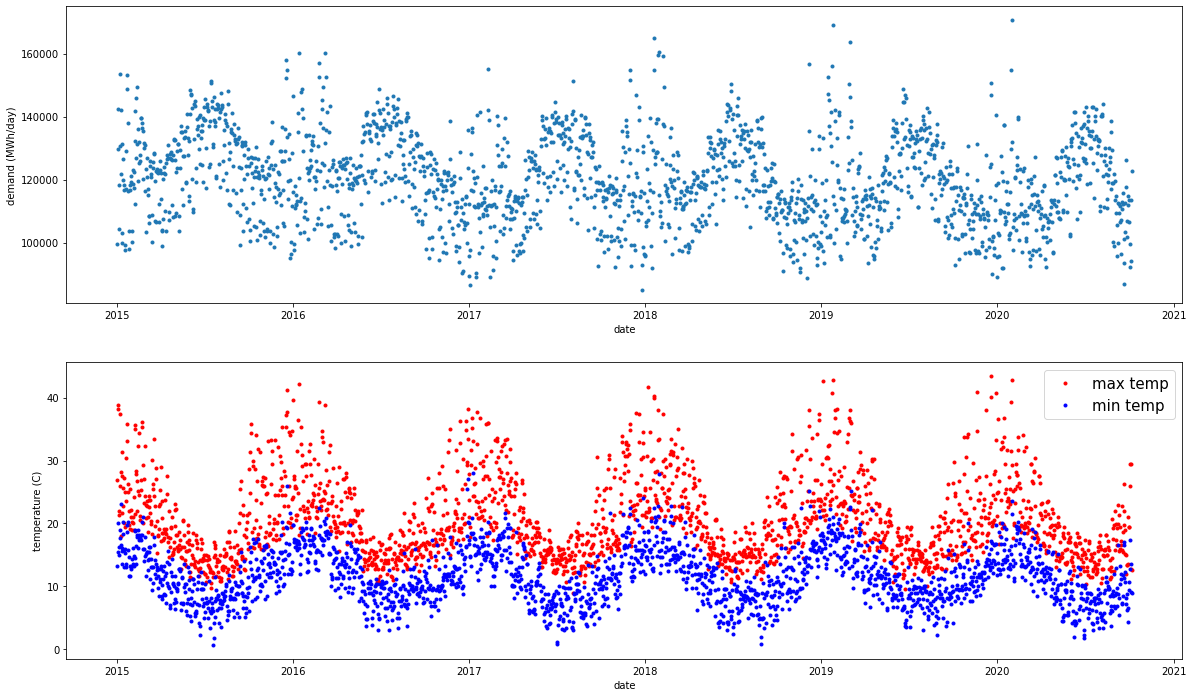

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
ax1.plot(data["date"], data["demand"], linestyle = "None", marker = ".")
ax2.plot(data["date"], data["max_temperature"], color = "red", label = "max temp", linestyle = "None", marker = ".")
ax2.plot(data["date"], data["min_temperature"], color = "blue", label = "min temp", linestyle = "None", marker = ".")
ax1.set_xlabel("date")
ax2.set_xlabel("date")
ax1.set_ylabel("demand (MWh/day)")
ax2.set_ylabel("temperature (C)")
ax2.legend(fontsize = 15)
plt.savefig('dataexp1', bbox_inches = 'tight')
plt.show()

A closer look at the numbers show a slow, but continuously decreasing trend in total annual electricity demand. A reminder that 2020 data is not complete.

In [10]:
annual_demand = data.loc[data["date"].dt.dayofyear <= datetime.date(2020, 10, 6).timetuple().tm_yday]
annual_demand = annual_demand.groupby(data["date"].map(lambda x: x.year)).sum().reset_index()
annual_demand[["date", "demand"]]

,date,demand
0,2015,3.536013e+07
1,2016,3.495815e+07
2,2017,3.366643e+07
3,2018,3.411540e+07
4,2019,3.369887e+07
5,2020,3.281317e+07


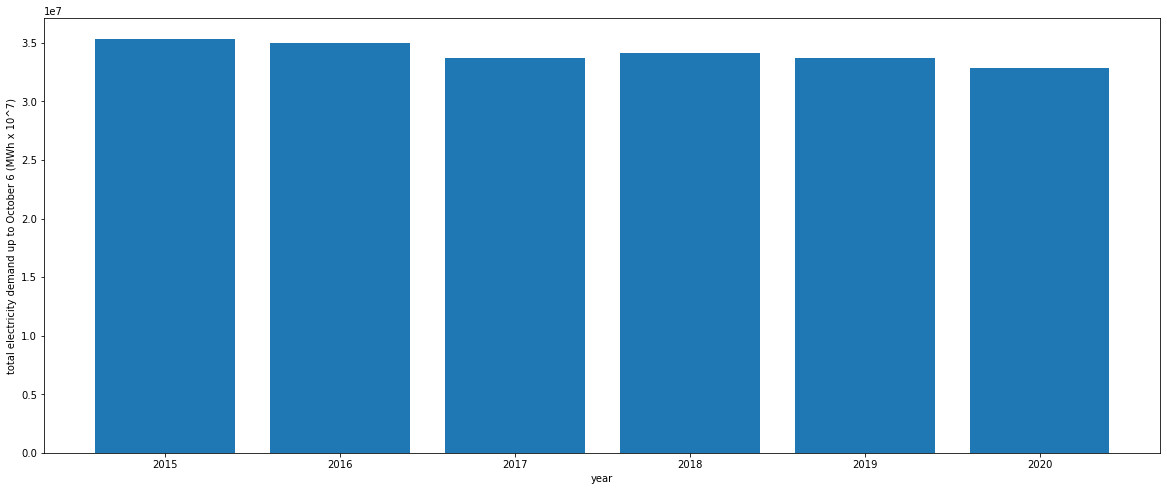

In [11]:
fig, ax1 = plt.subplots(figsize=(20, 8))
ax1.bar(annual_demand["date"], annual_demand["demand"])
ax1.set_xlabel("year")
ax1.set_ylabel("total electricity demand up to October 6 (MWh x 10^7)")
plt.savefig('dataexp2', bbox_inches = 'tight')
plt.show()

#### 2. A more detailed look.

Since we have the data, let's take a closer look at the electricity usage at positive and negative RRP levels. We see that as the winter months of 2020 come to an end, the dip in positive RRP demand is much lower than the previous 5 years. We did not see this dip in the plot above, since this demand was made up by a higher than usual increase in negative RRP demand.

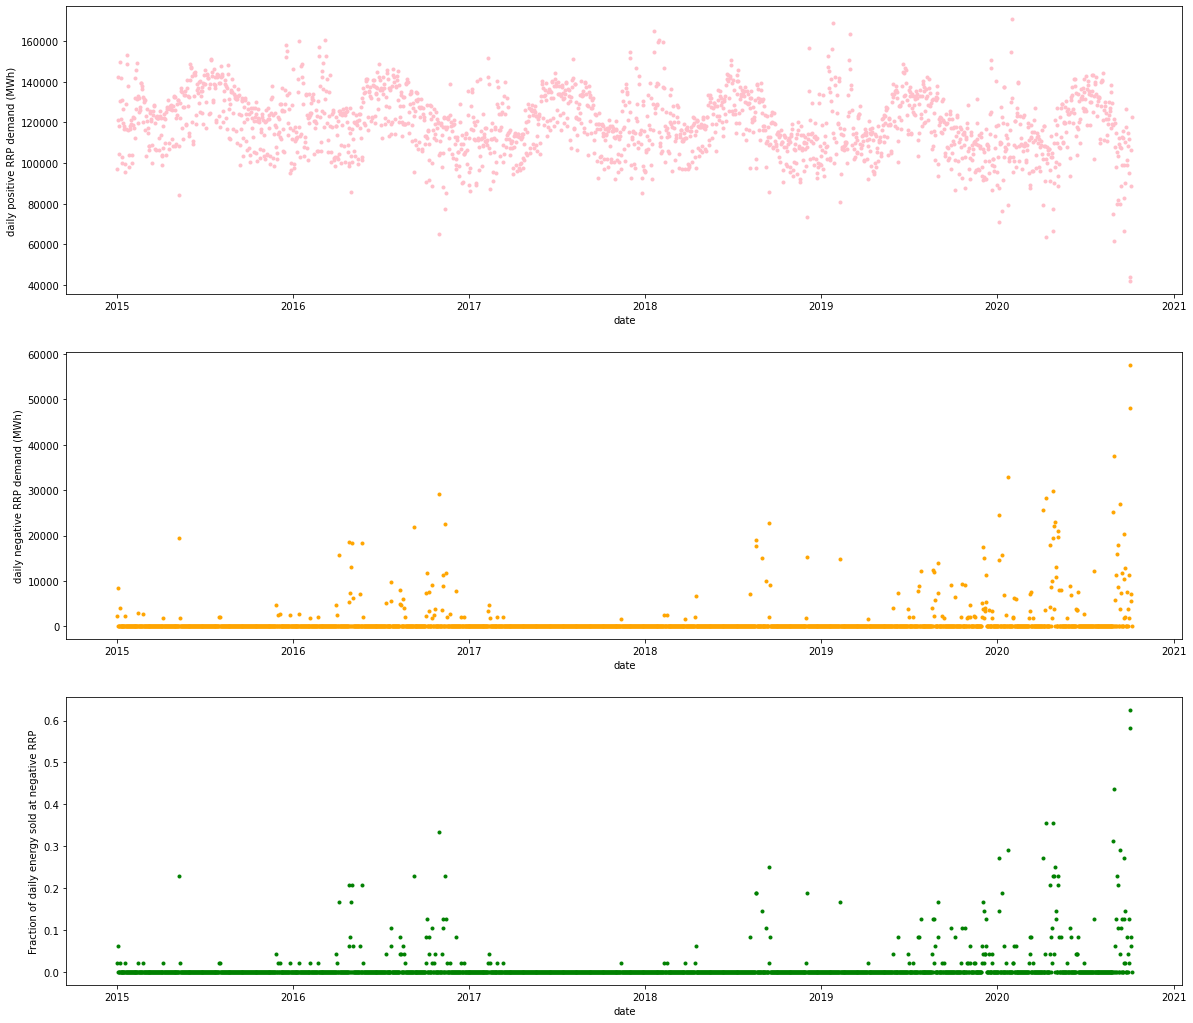

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 18))
ax1.plot(data["date"], data["demand_pos_RRP"], color = "pink", linestyle = "None", marker = ".")
ax2.plot(data["date"], data["demand_neg_RRP"], color = "orange", linestyle = "None", marker = ".")
ax3.plot(data["date"], data["frac_at_neg_RRP"], color = "green", linestyle = "None", marker = ".")
ax1.set_xlabel("date")
ax2.set_xlabel("date")
ax3.set_xlabel("date")
ax1.set_ylabel("daily positive RRP demand (MWh)")
ax2.set_ylabel("daily negative RRP demand (MWh)")
ax3.set_ylabel("Fraction of daily energy sold at negative RRP")
plt.savefig('dataexp3', bbox_inches = 'tight')
plt.show()

A report from the ACCC (https://www.accc.gov.au/system/files/Inquiry%20into%20the%20National%20Electricity%20Market%20-%20Supplementary%20report.pdf) gives us more insights into the observations we made above. Some key points:

- "The COVID-19 pandemic has significantly affected electricity customers. Overall, demand across the National Electricity Market (NEM) was down just 2 per cent in Q2 2020 compared to Q2 2019 with increased residential consumption largely offsetting the decrease in business consumption."

- ". In Victoria, [...], households consumed between 10 and 30 per cent more electricity between April and May this year compared with last year. This is due to the combination of colder weather this year and the COVID-19 restrictions keeping people at home. Victorian Small and Medium-sized enterprises (SME) consumed between 10 and 20 per cent less during the same period.

- "This has translated into greater concerns about paying energy bills, which has increased over the course of the CPRC’s study. [...] 17 per cent of respondents in July were more active in managing their energy bills compared to 10 per cent of respondents in June."

With what we learn from the report, it is possible that the increase in negative RRP demand due to the fact that people are actively making an effort to reduce their energy bills, and consuming their energy when RRP is likely to be lower (off-peak times).

Dashboard where you can see wholesale electricity prices (note peak times): https://aemo.com.au/en/energy-systems/electricity/national-electricity-market-nem/data-nem/data-dashboard-nem. In Australia, retailers are required by law to pass cost savings onto consumers.

#### 3. Other variables

We don't really expect noteworthy from the remaining variables, but let's take a look just in case.

Solar Exposure: As expected, clear cyclical pattern (we should be very concerned if we saw an anomaly!)

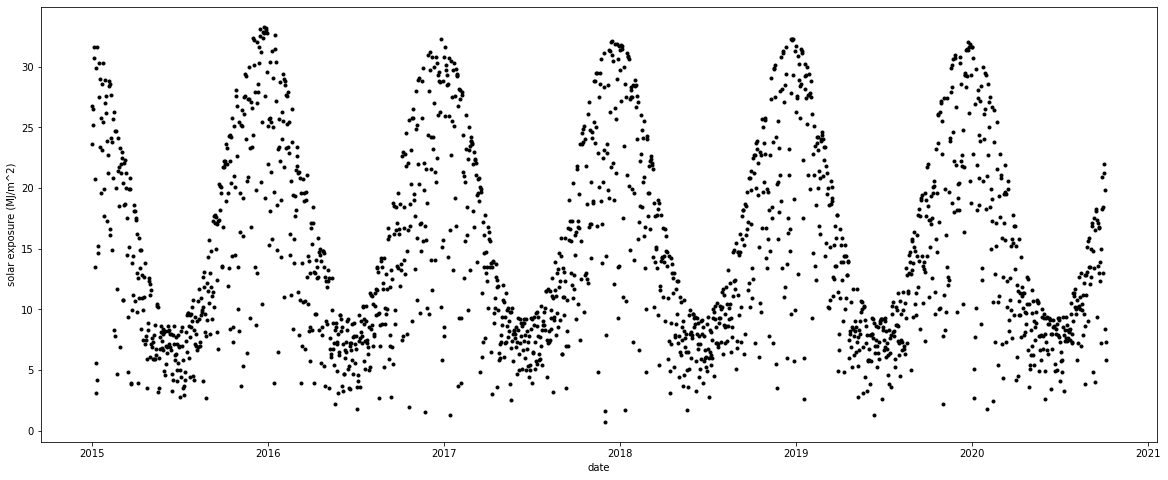

In [13]:
fig, ax1 = plt.subplots(figsize=(20,8))
ax1.plot(data["date"], data["solar_exposure"], color = "black", linestyle = "None", marker = ".")
ax1.set_xlabel("date")
ax1.set_ylabel("solar exposure (MJ/m^2)")
plt.savefig('dataexp4', bbox_inches = 'tight')
plt.show()

Rainfall: it looks like 2020 has seen the most rain since 2015 (and we only have data up to October!). Particularly, the beginning of 2020 had some very rainy days. Other than that, no specific patterns we can see.

In [14]:
rf = data.groupby(data["date"].map(lambda x: x.year)).sum().reset_index()
rf[["date", "rainfall"]]

,date,rainfall
0,2015,439.2
1,2016,599.6
2,2017,602.0
3,2018,514.4
4,2019,374.4
5,2020,637.4


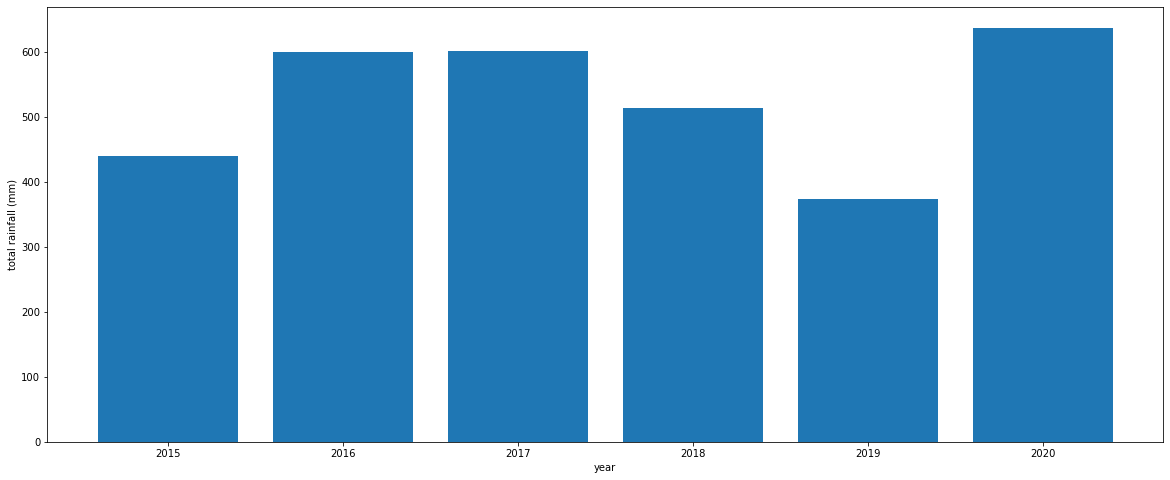

In [15]:
fig, ax1 = plt.subplots(figsize=(20, 8))
ax1.bar(rf["date"], rf["rainfall"])
ax1.set_xlabel("year")
ax1.set_ylabel("total rainfall (mm)")
plt.savefig('dataexp5', bbox_inches = 'tight')
plt.show()

School days and holidays:

Since our data for 2020 only goes until October 6th, we should take a look at this period (Jan 1 - Oct 6) for every year to compare.

The number of holidays fluctuates depending on timing of holidays before/after the cutoff (Oct 6). Checking against the Victorian public holiday calendar (https://www.business.vic.gov.au/victorian-public-holidays-and-daylight-saving/victorian-public-holidays), it appears that in our dataset, if a holiday falls on a weekend, the holiday is double counted (once on the actual holiday on the weekend, and once on the observed holiday on a weekday).

We see that school days are significantly lower in 2020 (due to COVID restrictions).

In [16]:
relevant_period = data.loc[data["date"].dt.dayofyear <= datetime.date(2020, 10, 6).timetuple().tm_yday]
relevant_period = relevant_period.groupby(data["date"].map(lambda x: x.year)).sum().reset_index()[["date", "school_day", "holiday"]]
relevant_period

,date,school_day,holiday
0,2015,198,9
1,2016,198,10
2,2017,197,11
3,2018,196,10
4,2019,195,11
5,2020,105,10


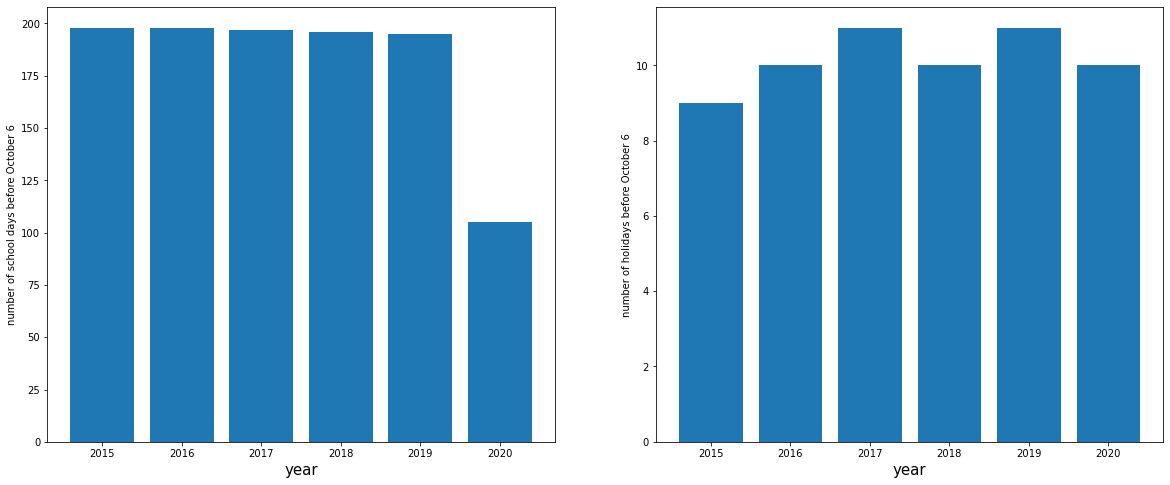

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.bar(relevant_period["date"], relevant_period["school_day"])
ax1.set_xlabel("year", fontsize = 15)
ax1.set_ylabel("number of school days before October 6")
ax2.bar(relevant_period["date"], relevant_period["holiday"])
ax2.set_xlabel("year", fontsize = 15)
ax2.set_ylabel("number of holidays before October 6")
plt.savefig('dataexp6', bbox_inches = 'tight')
plt.show()

In [18]:
# why does 2015 have 2 fewer holidays?
relevant_period = data.loc[data["date"].dt.dayofyear <= datetime.date(2020, 10, 6).timetuple().tm_yday]

holidays2015 = relevant_period.loc[relevant_period["holiday"] == 1]
holidays2015 = holidays2015.loc[holidays2015["date"].dt.year == 2015]
holidays2015["date"]

0     2015-01-01
25    2015-01-26
67    2015-03-09
92    2015-04-03
93    2015-04-04
95    2015-04-06
114   2015-04-25
158   2015-06-08
274   2015-10-02
Name: date, dtype: datetime64[ns]

In [19]:
# compare to 2020... because holidays on weekends are double counted
holidays2020 = relevant_period.loc[relevant_period["holiday"] == 1]
holidays2020 = holidays2020.loc[holidays2020["date"].dt.year == 2020]
holidays2020["date"]

1826   2020-01-01
1851   2020-01-26
1852   2020-01-27
1894   2020-03-09
1926   2020-04-10
1927   2020-04-11
1928   2020-04-12
1929   2020-04-13
1941   2020-04-25
1985   2020-06-08
Name: date, dtype: datetime64[ns]

### Model 1: Univariate Model

Prophet is a time series forecasting tool from Facebook. Though it is still under development, it's implementation much faster than the traditional methods (e.g. ARIMA, which would take a really long time since our dataset has a seasonal differencing period of  365 days).

In [20]:
model1 = Prophet(daily_seasonality = False, weekly_seasonality = True, yearly_seasonality = True, interval_width = 0.95)
history = data.rename(columns = {"date": "ds", "demand": "y"}, inplace = False)
model1.fit(history)

In [21]:
forecast = model1.predict()

Trend appears to be in line with what we observed earlier (slightly decreasing).

Weekly seasonality component gives us some new insight; weekday usage appears flat, while weekend usage is less. Not surprising.

Yearly seasonality component behaves mostly as expected (lower in the summer, higher in the winter). However, the shape is not as smooth as one might expect (notice bumps during Feburary/March/December - can we smooth those out?).

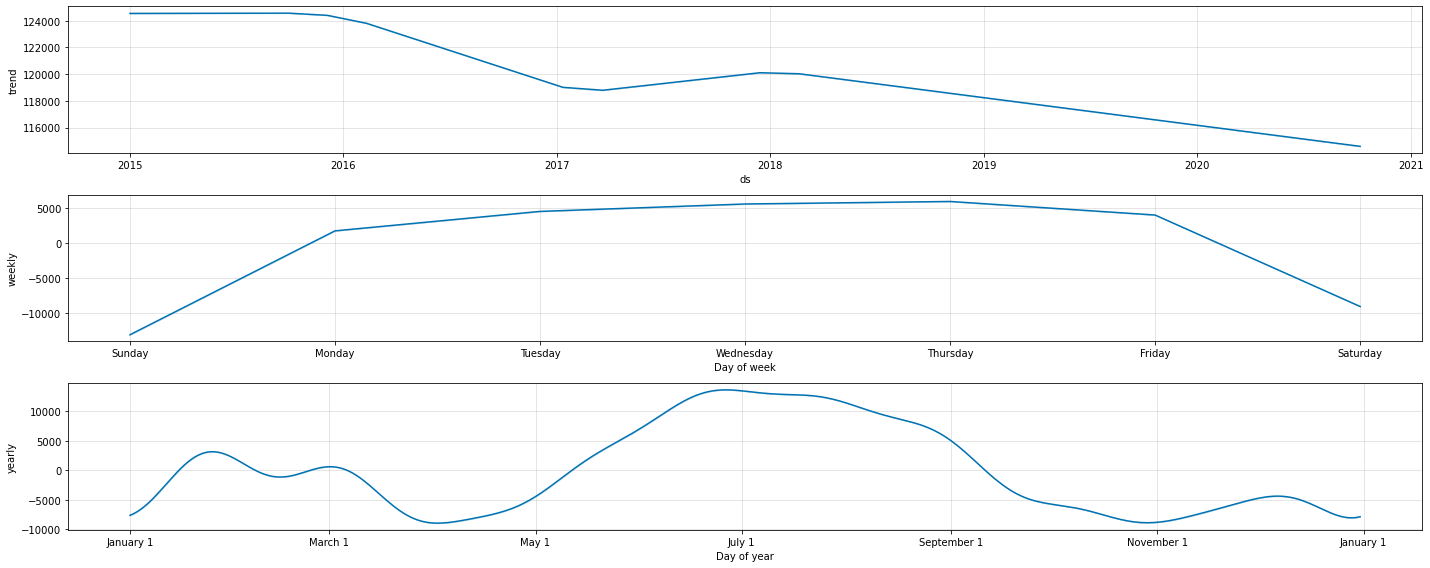

In [22]:
fig = model1.plot_components(forecast, figsize = (20, 8))
fig.savefig('model1', bbox_inches = 'tight')

Dark blue line shows the model fit, light blue area is a 80% uncertainty (prediction) interval. There seem to be a lot of points which fall out of the uncertainty interval, particularly during the summer months.

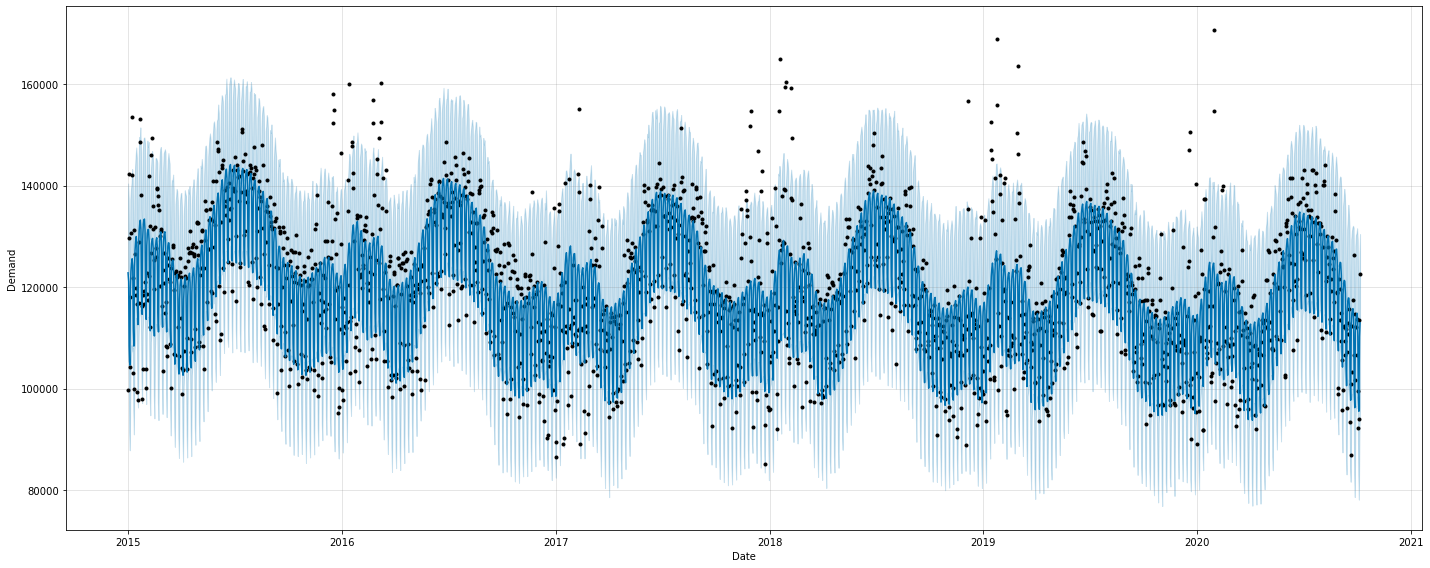

In [23]:
fig = model1.plot(forecast, xlabel = "Date", ylabel = "Demand",figsize = (20, 8))
fig.savefig('model1_pred', bbox_inches = 'tight')

#### Model Evaluation

Using residual plot for model evaluation, there appear to be a few issues:
 - There still seems to be a slight wave pattern in visible in the residual plot (maybe it's more visible if you squint).
 - The residuals are heteroskedastic. The variability appears to get larger during summer months.
 - We'd also like to reduce the variability of the residuals overall. The variability of the residual is similar to the scale of our seasonal components, which limits the usefulness of our model.

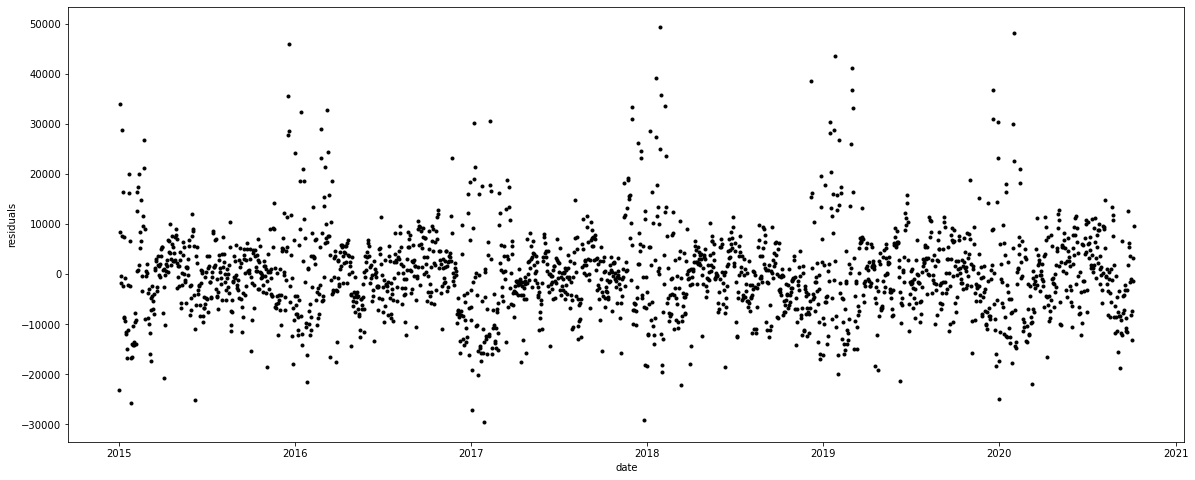

In [24]:
# calculating resiudals
df = pd.merge(history, forecast, on = 'ds')
df["residuals"] = df['y'] - df['yhat']

# plotting residuals
fig, ax1 = plt.subplots(figsize=(20,8))
ax1.plot(df["ds"], df["residuals"], linestyle = "None", marker = ".", color = "black")
ax1.set_xlabel("date")
ax1.set_ylabel("residuals")
plt.savefig('model1_resid', bbox_inches = 'tight')
plt.show()

#### Diagnostics

Performing cross validation and gathering statistics for model evaluation.

In [25]:
# 2 years training data, spacing predictions 180 days, forecast horizon of 365 days.
df_cv = cross_validation(model1, initial = '730 days', period = '180 days', horizon = '365 days')
df_cv

INFO:fbprophet:Making 6 forecasts with cutoffs between 2017-04-20 00:00:00 and 2019-10-07 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-04-21,113948.482938,98197.754843,130506.236400,114522.440,2017-04-20
1,2017-04-22,100336.232982,83484.496000,115812.872327,102528.400,2017-04-20
2,2017-04-23,95970.528506,80449.696132,111729.221046,97356.565,2017-04-20
3,2017-04-24,111619.241135,94341.169386,128242.084782,109421.815,2017-04-20
4,2017-04-25,115690.309618,99020.554454,131706.216671,101548.735,2017-04-20
...,...,...,...,...,...,...
2185,2020-10-02,113459.105727,97365.439819,130967.165948,99585.835,2019-10-07
2186,2020-10-03,100260.039425,82186.474288,118058.390996,92277.025,2019-10-07
2187,2020-10-04,95977.154261,78395.419145,112770.183638,94081.565,2019-10-07
2188,2020-10-05,110940.997048,94100.537696,127518.948492,113610.030,2019-10-07


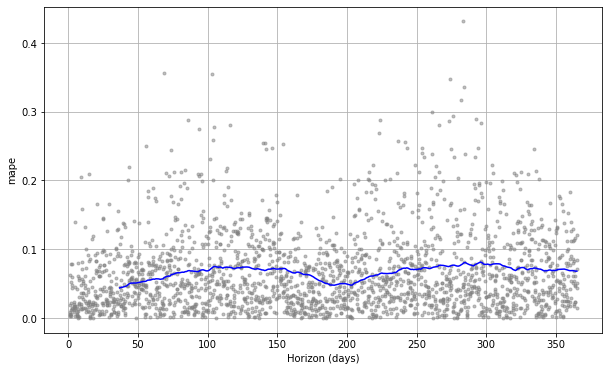

In [26]:
# mse, rmse, mae, mape, mdape, coverage
fig = plot_cross_validation_metric(df_cv, metric='mape')
fig.savefig("model1_cv", bbox_inches = 'tight')

### Model 2: Multivariate Model

In the second iteration of the model, we include the other regressors in our dataset which would be useful in prediction.

Note: RRP related variables a function of demand (therefore are not predictive) and shouldn't be used in our model. Furthermore, practically, the marginal consumption of electricity day-to-day is not based on present RRP. (You don't check the RRP before deciding whether or not to turn on a light).

Additionally, we perform a few extra steps to refine our model, rather than just throwing all the variates in and hoping for the best.

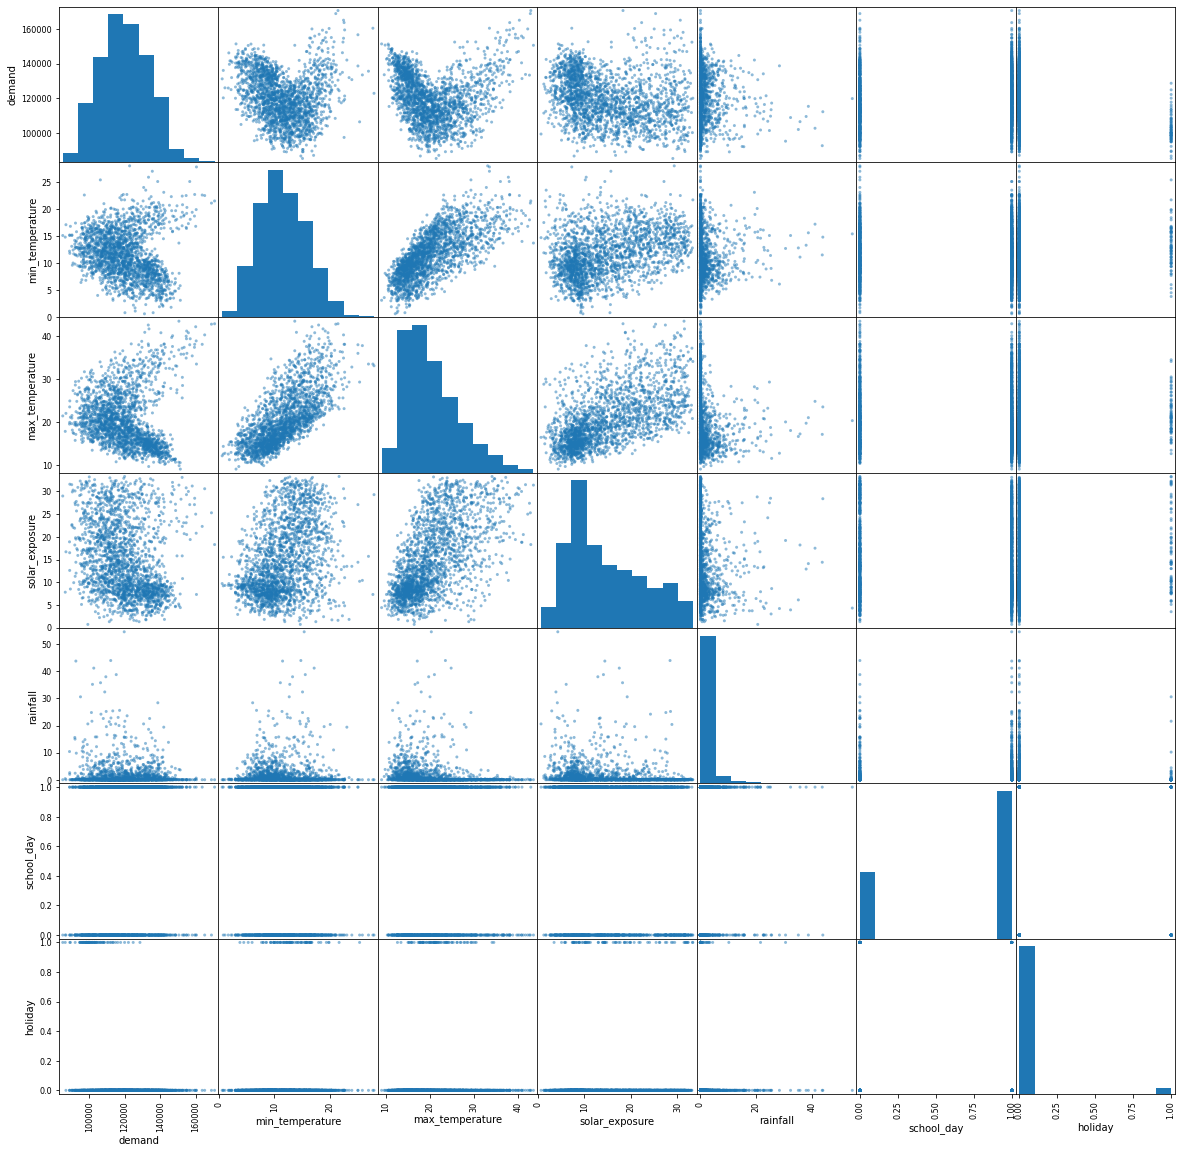

In [27]:
# Pairs plot
pairsplot = pd.plotting.scatter_matrix(data[["demand", "min_temperature", "max_temperature", "solar_exposure", "rainfall",
                                             "school_day", "holiday"]], figsize = (20, 20))
plt.savefig('pairsplot1', bbox_inches = 'tight')

#### 1. Feature Engineering

Instead of using min/max temperatures as variates, combine them. The idea is that if the temperature is comfortable (about room temperature, 20C), then neither heating nor air conditioning will be used. If the temperature is not comfortable (either too cold or too hot), then more electricity will be used. So we should create a variable based on the absolute deviation from this temperature.

Not sure if too hot is "worth" the same as too cold. 

Inituition is that more electricity is used if it is too hot rather than if it is too cold.

For example, if it is too cold, gas heaters are an alternative which may not increase the electricity demand more than if it were too hot, as air conditioning does not have a similar alternative. 

Solution: split into two (hot and cold), and make sure NOT TO STANDARDIZE

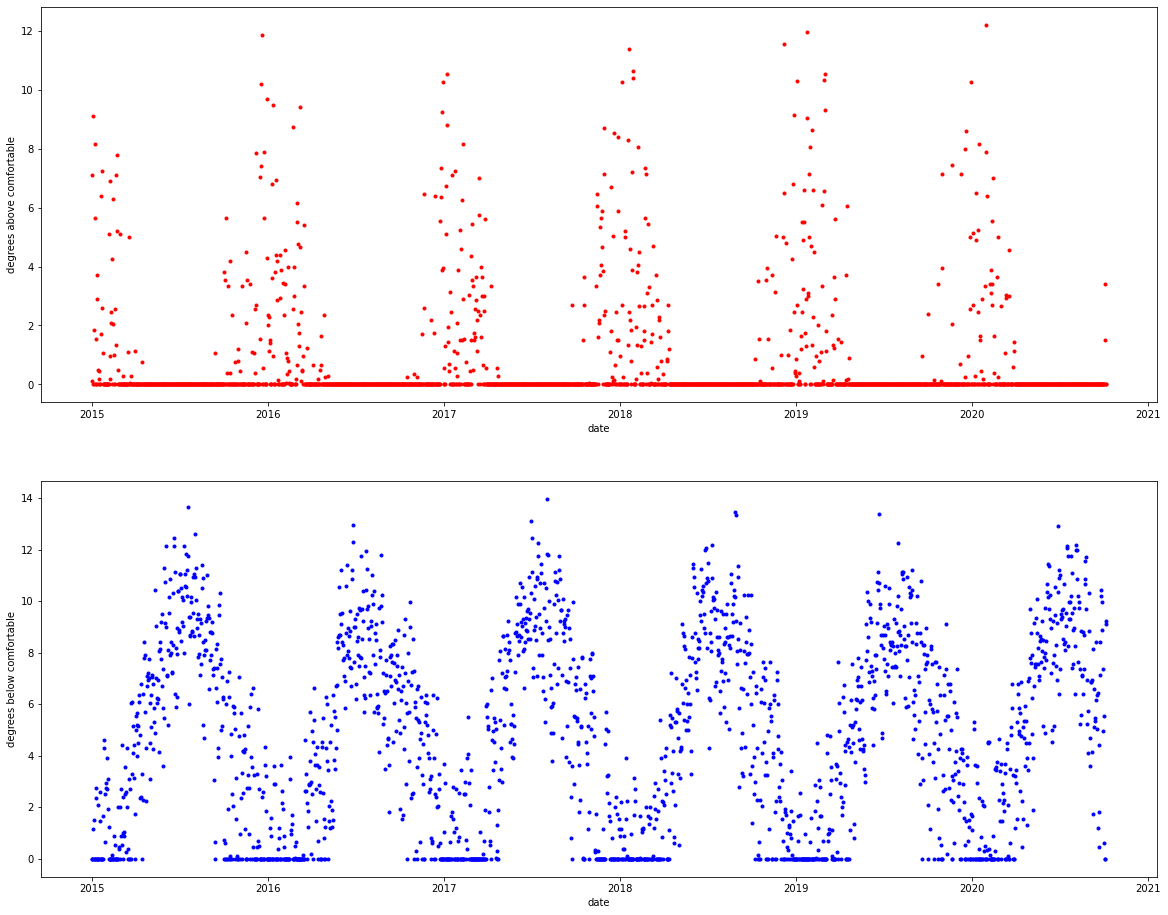

In [28]:
data["mean_temp"] = (data["max_temperature"] + data["min_temperature"])/2

too_hot = (data["mean_temp"] - 20)
too_hot = too_hot.mask(too_hot < 0, other = 0).abs()
data["too_hot"] = too_hot

too_cold = (data["mean_temp"] - 20)
too_cold = too_cold.mask(too_cold > 0, other = 0).abs()
data["too_cold"] = too_cold


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,16))
ax1.plot(data["date"], data["too_hot"], color = "red", linestyle = "None", marker = ".")
ax1.set_xlabel("date")
ax1.set_ylabel("degrees above comfortable")
ax2.plot(data["date"], data["too_cold"], color = "blue", linestyle = "None", marker = ".")
ax2.set_xlabel("date")
ax2.set_ylabel("degrees below comfortable")
plt.savefig("feateng", bbox_inches = "tight")
plt.show()

#### 2. Feature Selection

In the pairs plot below, the most important row is the top row, which shows the relationship between electricity demand and each of the variables.

Demand vs.:
- Min temp/Max temp: not linear, would not be suitable for our linearly additive model. This is actually remedied by our "too_hot" and "too_cold" variables.
- too_hot and too_cold: mostly positive correlation, but note how there are several points piled up around 0. We have to make sure not to standardize this variable.
- Solar exposure: Very weak relationship, if any
- Rainfall: no visible relationship
- School day: no visible relationship
- Holiday: appears to be a weak relationship.

So let's build a model with the these three variables: Too hot, too cold, and Holiday.


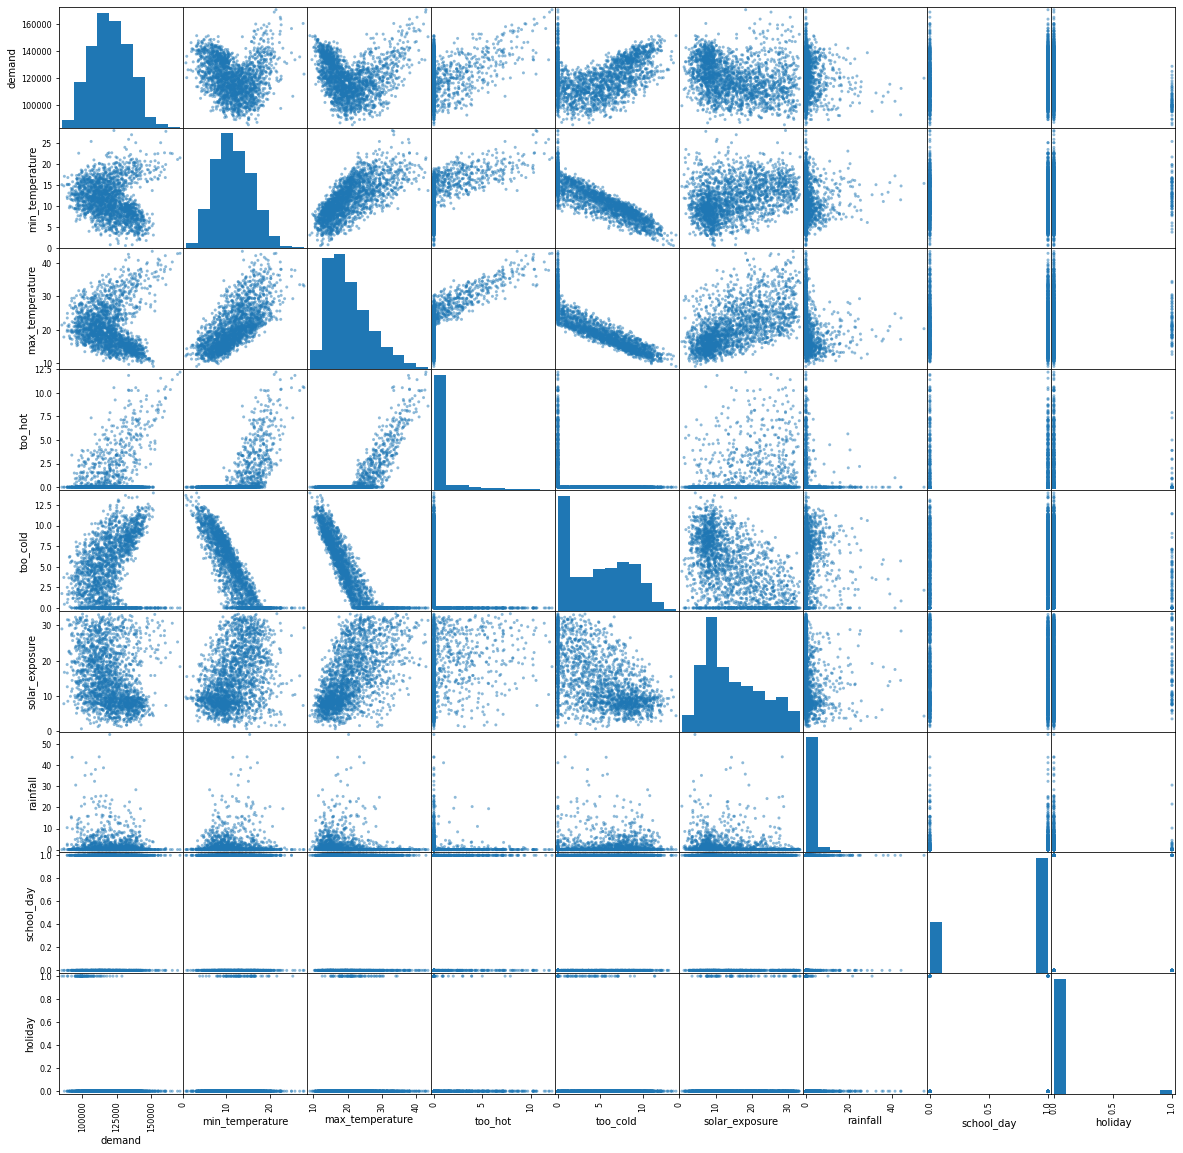

In [29]:
# Pairs plot
pairsplot = pd.plotting.scatter_matrix(data[["demand", "min_temperature", "max_temperature", "too_hot", "too_cold",
                                             "solar_exposure", "rainfall", "school_day", "holiday"]], figsize = (20, 20))

Now, build.

In [30]:
# Holidays to add in the model.
# There is unlikely to be an effect of holidays on top of weekend, only include holidays observed on weekdays.
history = data.rename(columns = {"date": "ds", "demand": "y"}, inplace = False)

weekday_holidays = history.loc[history["holiday"] == 1]["ds"].reset_index(drop = True)
weekday_holidays = weekday_holidays.loc[~(weekday_holidays.dt.dayofweek.isin([5,6]))].reset_index(drop = True)

holidays = pd.DataFrame({
  'holiday': 'weekday holiday',
  'ds': weekday_holidays,
  'lower_window': 0,
  'upper_window': 1,
})

In [31]:
model2 = Prophet(daily_seasonality = False, weekly_seasonality = True, yearly_seasonality = True, 
                 holidays = holidays, interval_width = 0.95)
model2.add_regressor("too_hot", standardize = False)
model2.add_regressor("too_cold", standardize = False)
model2.fit(history)

In [32]:
forecast = model2.predict()

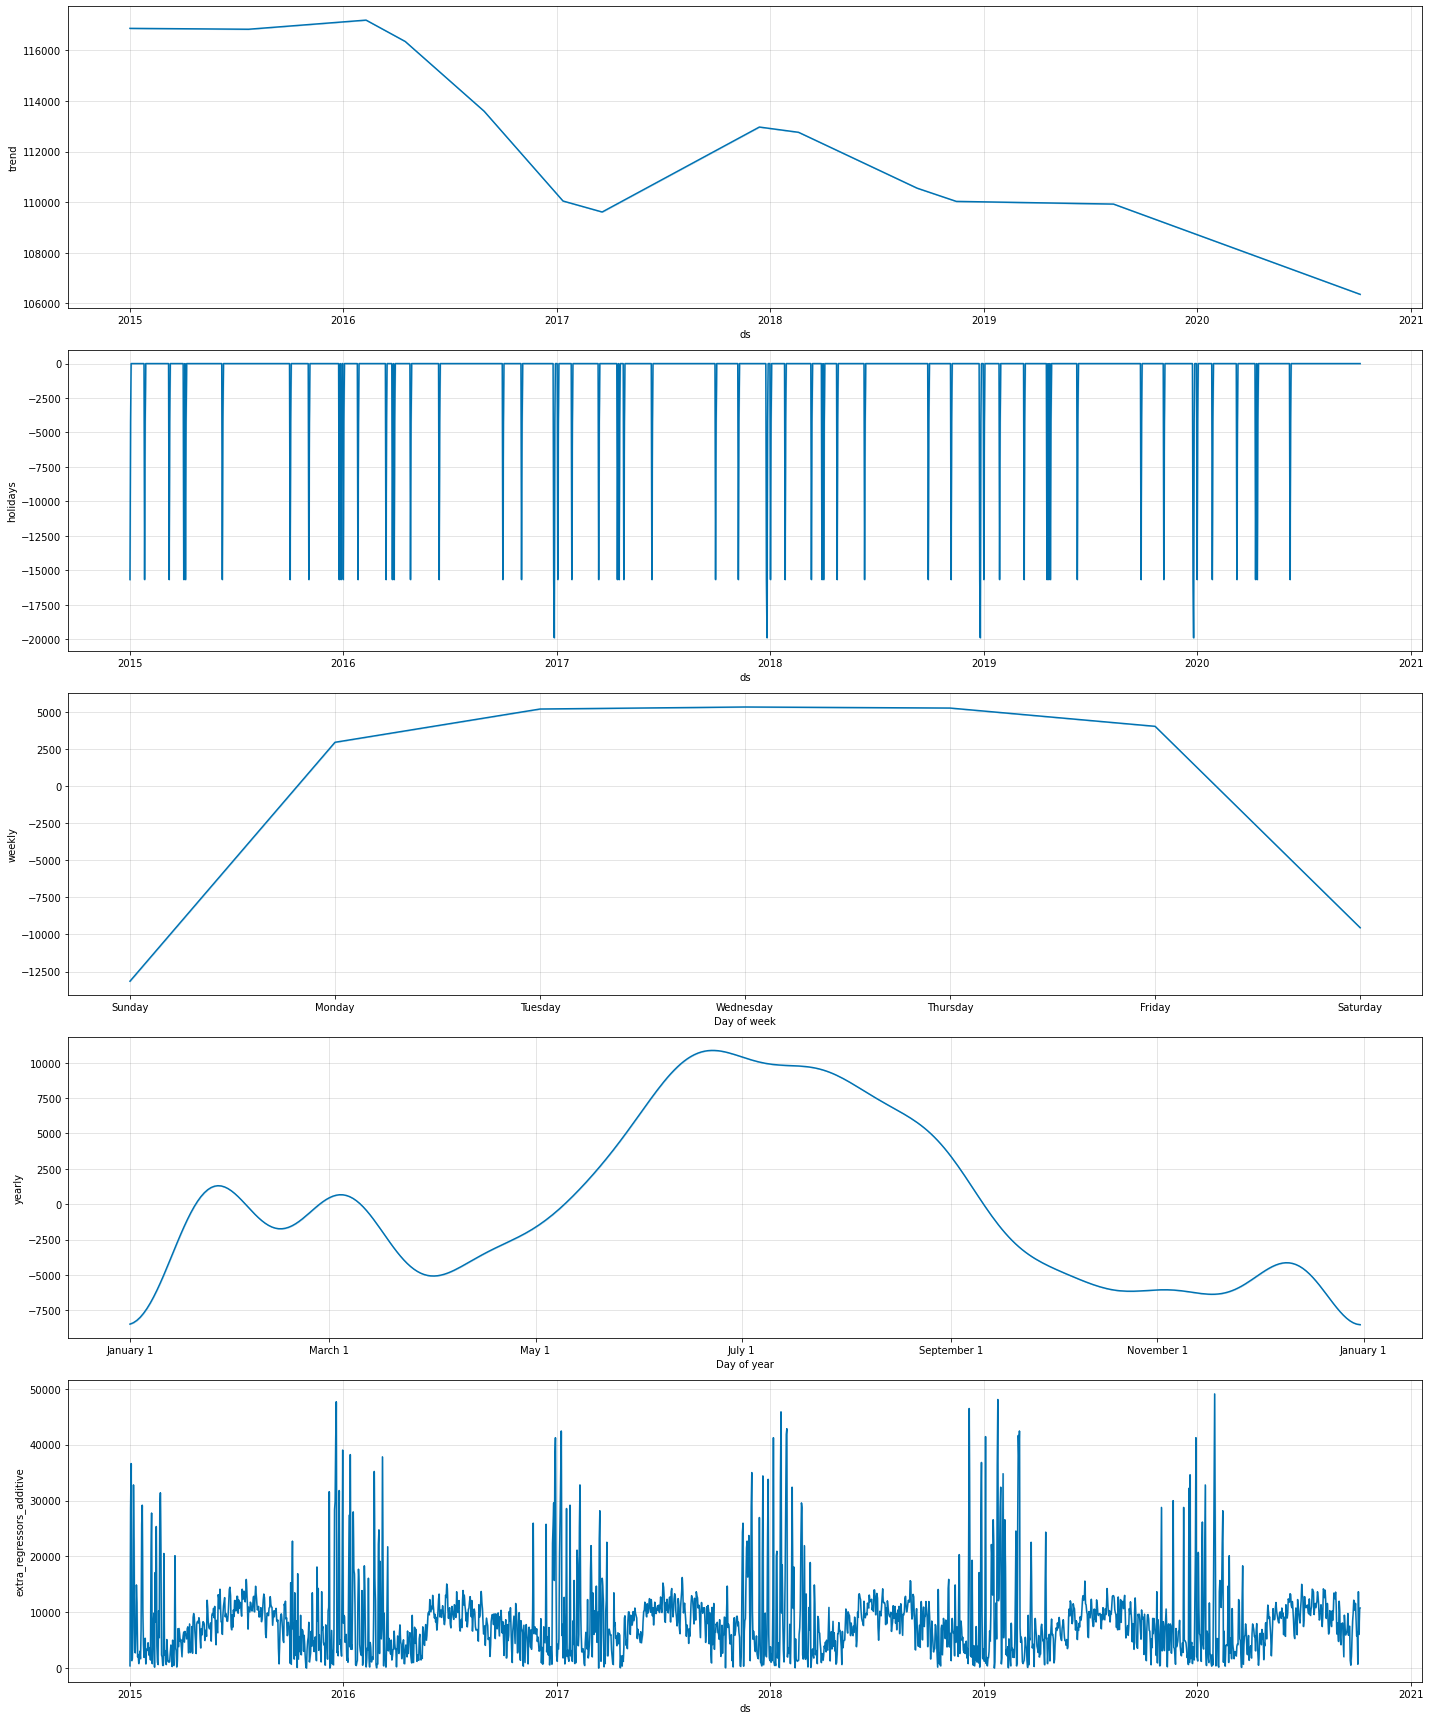

In [33]:
fig = model2.plot_components(forecast, figsize = (20, 24))
fig.savefig('model2', bbox_inches = 'tight')

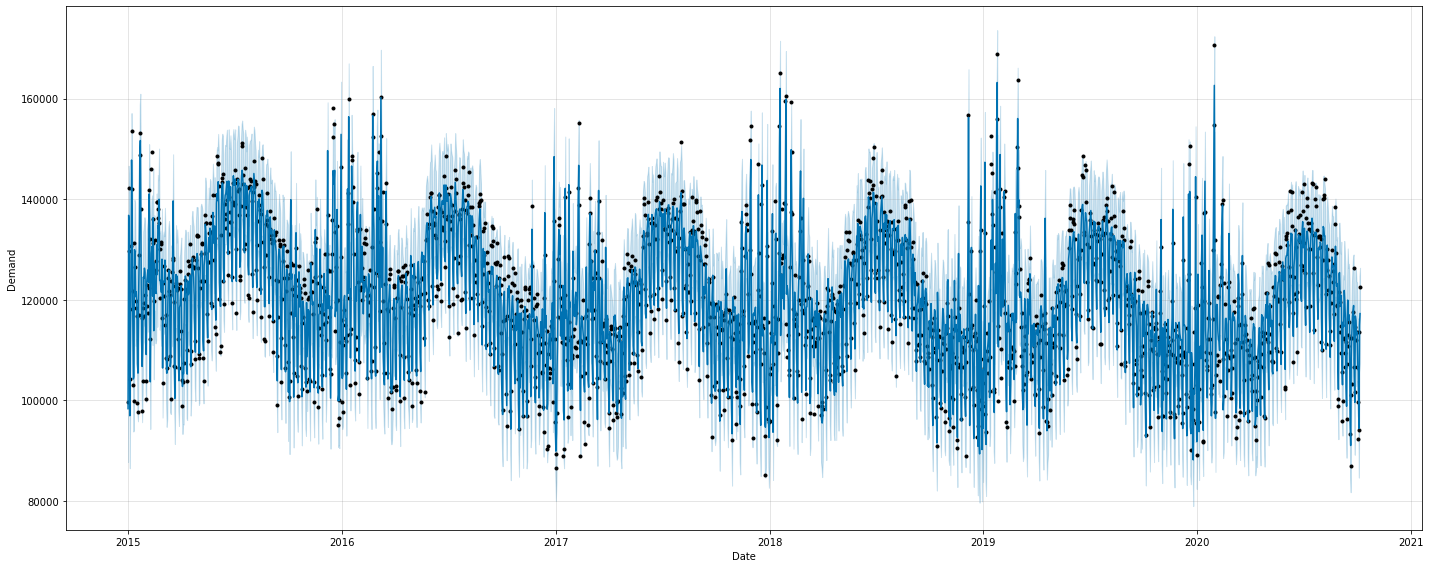

In [34]:
fig = model2.plot(forecast, xlabel = "Date", ylabel = "Demand", figsize = (20, 8))
fig.savefig('model2_pred', bbox_inches = 'tight')

#### Model Evaluation

Plotting the residuals again, we've improved upon the univariate model in several ways:

- We've eliminated some of the waviness in the residual plot.
- We've reduced the variability of the residuals (compare the y-axis scaling to the previous residual plot).

The "spikes" during the summer months are still visible, but much less prominent.

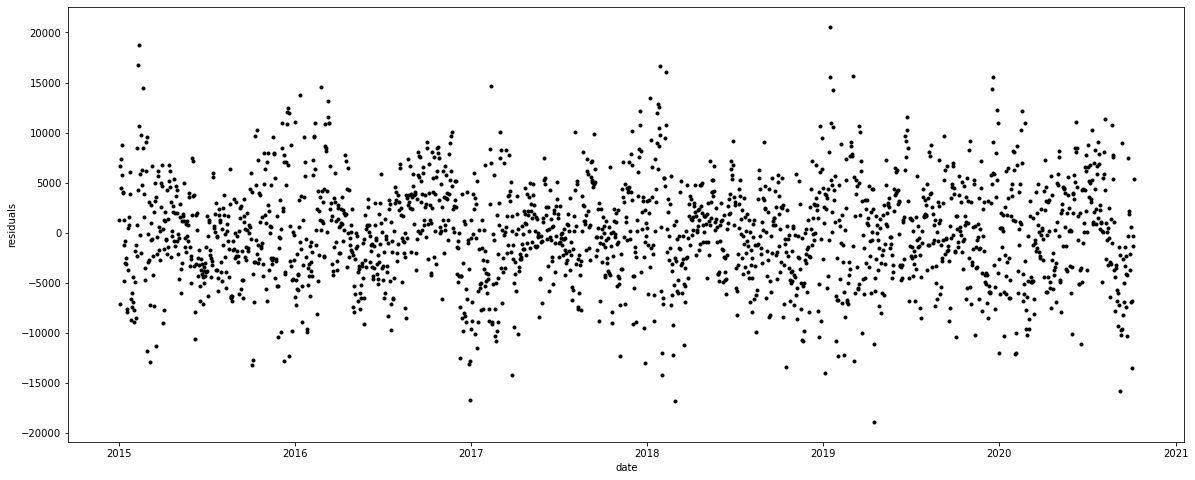

In [35]:
# calculating resiudals
df = pd.merge(history, forecast, on = 'ds')
df["residuals"] = df['y'] - df['yhat']

# plotting residuals
fig, ax1 = plt.subplots(figsize=(20,8))
ax1.plot(df["ds"], df["residuals"], linestyle = "None", marker = ".", color = "black")
ax1.set_xlabel("date")
ax1.set_ylabel("residuals")
plt.savefig('model2_resid', bbox_inches = 'tight')
plt.show()

In [36]:
df["residuals"].std()

5045.271101720482

#### Diagnostics

Performing cross validation and gathering statistics for model evaluation.

In [37]:
# 2 years training data, spacing predictions 180 days, forecast horizon of 365 days.
df_cv = cross_validation(model2, initial = '730 days', period = '180 days', horizon = '365 days')
df_cv

INFO:fbprophet:Making 6 forecasts with cutoffs between 2017-04-20 00:00:00 and 2019-10-07 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-04-21,111763.622661,102508.034035,121271.523732,114522.440,2017-04-20
1,2017-04-22,95519.501160,86556.524520,104800.769684,102528.400,2017-04-20
2,2017-04-23,92355.279972,83065.404331,101269.437800,97356.565,2017-04-20
3,2017-04-24,109197.180714,100077.679057,118052.450872,109421.815,2017-04-20
4,2017-04-25,96168.925979,86550.693027,105893.047303,101548.735,2017-04-20
...,...,...,...,...,...,...
2185,2020-10-02,111650.841188,100198.398044,122890.022620,99585.835,2019-10-07
2186,2020-10-03,110423.731572,99175.935231,121675.038170,92277.025,2019-10-07
2187,2020-10-04,98993.728612,86799.787082,110685.513121,94081.565,2019-10-07
2188,2020-10-05,119206.083656,107832.713979,130417.526979,113610.030,2019-10-07


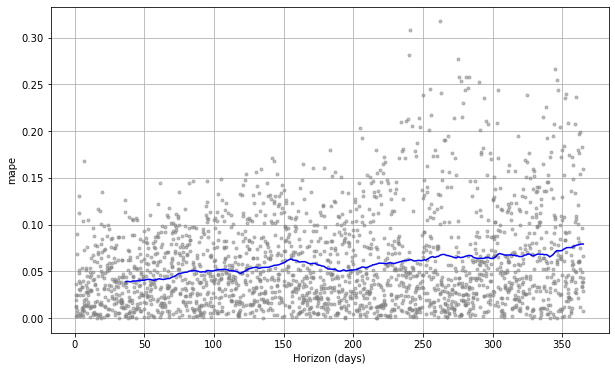

In [38]:
# mse, rmse, mae, mape, mdape, coverage
fig = plot_cross_validation_metric(df_cv, metric='mape')
fig.savefig("model2_cv", bbox_inches = 'tight')